# Dog/Cat Convolutional Classificator with TensorFlow

## Импорт библиотек

In [1]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

tf.test.gpu_device_name()

## Построение модели

Модель будет начинаться со слоя `Rescaling`, преобразующего входные данные (значения которых изначально находятся в диапазоне [0, 255]) в диапазон [0, 1]. Далее будет идти множество слоев `Conv2D` и `MaxPooling2D` (стандартный набор для сверточной нейронной сети). Также, в качестве борьбы с переобучением добавлено обогащение данных и прореживание. Заканчиваться модель будет слоем `Dense` с 1 выходом и функцией активации `sigmoid`, так как перед нами стоит задача бинарной классификации.

In [2]:
data_augmentation = keras.Sequential([
	keras.layers.RandomFlip('horizontal'), 
	keras.layers.RandomRotation(0.1), 
	keras.layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))  # Вход: Изображения RGB 180x180
x = data_augmentation(inputs)  # Обогащение данных
x = keras.layers.Rescaling(1./255)(x)  # Преобразование [0, 255] -> [0, 1] при помощи деления на 255
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)  # Прореживание
outputs = keras.layers.Dense(1, activation='sigmoid')(x)  # Выход: Результат классификации

model = keras.Model(inputs=inputs, outputs=outputs, name='dogsvscats')  # Собственно модель
model.summary()

Model: "dogsvscats"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

На этапе компиляции используем стандартный оптимизатор `RMSprop`. Так как модель заканчивается единственным сигмоидным выходом, используем функцию потерь `binary_crossentropy`.

In [3]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

## Загрузка данных

Для загрузки данных воспользуемся встроенной в Keras функцией `image_dataset_from_directory()`, которая позволит быстро настроить конвейер обработки для автоматического преобразования файлов с изображениями в пакеты готовых тензоров.

In [4]:
train_dataset = keras.utils.image_dataset_from_directory(
    '../data/cats_vs_dogs_small/train',
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = keras.utils.image_dataset_from_directory(
    '../data/cats_vs_dogs_small/validation',
    image_size=(180, 180),
    batch_size=32
)
test_dataset = keras.utils.image_dataset_from_directory(
    '../data/cats_vs_dogs_small/test',
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Обучение модели

Создадим обратный вызов, чтобы автоматически остановить обучение и сохранить лучший вариант модели. Далее обучим модель на ранее подготовленных данных.

In [5]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='../models/dogsvscats.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
		patience=2
    )
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5011 - loss: 0.7390 - val_accuracy: 0.5000 - val_loss: 0.6966
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5088 - loss: 0.6934 - val_accuracy: 0.5290 - val_loss: 0.6916
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5255 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.7128
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5880 - loss: 0.6826 - val_accuracy: 0.5870 - val_loss: 0.6695
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6343 - loss: 0.6446 - val_accuracy: 0.6390 - val_loss: 0.6320
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6673 - loss: 0.6179 - val_accuracy: 0.6770 - val_loss: 0.5942
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.7060 - loss: 0.5710 - val_accuracy: 0.7010 - val_loss: 0.5699
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7269 - loss: 0.5253 - val_accuracy: 0.6620 - val_lo

## Визуализация обучения

Построим графики изменения потерь и точности в процессе обучения модели.

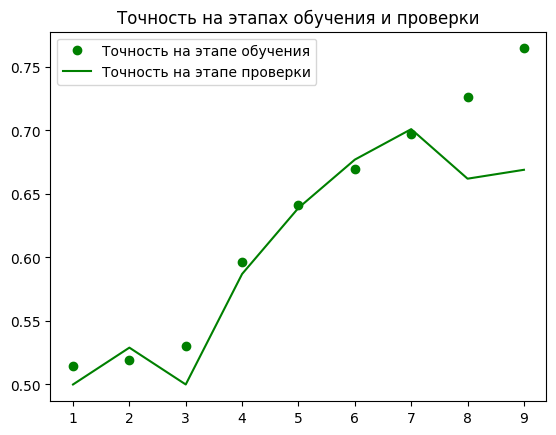

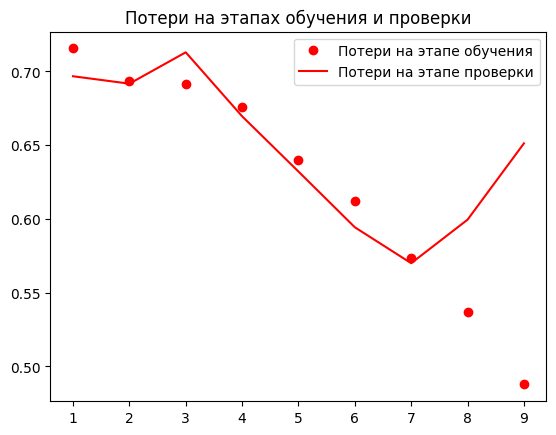

In [6]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'go', label='Точность на этапе обучения')
plt.plot(epochs, val_accuracy, 'g', label='Точность на этапе проверки')
plt.title('Точность на этапах обучения и проверки')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Потери на этапе обучения')
plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
plt.title('Потери на этапах обучения и проверки')
plt.legend()
plt.show()

## Тестирование модели

In [7]:
test_model = keras.models.load_model('../models/dogsvscats.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 485ms/step - accuracy: 0.7248 - loss: 0.5626
Test accuracy: 0.716
